# AWS Forecast Demo with ELE.ai (ETS)

In [1]:
# Libraries
import boto3
import datetime
import pandas as pd
from time import sleep
from io import StringIO
import matplotlib.pyplot as plt

## Step 1: Configure the CLI

download SDK files from [github](https://github.com/aws-samples/amazon-forecast-samples/tree/master/sdk) and [configure CLI ](https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-set-up-aws-cli.html)

In [2]:
# Configures your AWS CLI to interact with AWS Forecast Service
! aws configure add-model --service-name forecast --service-model file://setup_files/forecast-2018-06-26.normal.json
! aws configure add-model --service-name forecastquery --service-model file://setup_files/forecastquery-2018-06-26.normal.json

## Step 2: Start Boto Session & Define S3 Bucket

In [3]:
session = boto3.Session(region_name='us-east-1') #also available in us-west-2
forecast = session.client(service_name='forecast')
forecastquery = session.client(service_name='forecastquery')

## Step 3: Define IAM role 

In [4]:
role_name = 'amazonforecast'
accountId = boto3.client('sts').get_caller_identity().get('Account')
role = 'arn:aws:iam::{}:role/{}'.format(accountId, role_name)

## Step 4: Load & Transform Dataset

### Target Time Series

### Upload to s3

## Step 5: Create Dataset & Dataset Group in AWS Forecast

## Step 7: Import Dataset in AWS Forecast

## Step 8: Train Predictor Model in AWS Forecast

In [5]:
# View Recipes
forecast.list_recipes()["RecipeNames"]

['forecast_ARIMA',
 'forecast_DEEP_AR',
 'forecast_DEEP_AR_PLUS',
 'forecast_ETS',
 'forecast_MDN',
 'forecast_MLP',
 'forecast_MQRNN',
 'forecast_NPTS',
 'forecast_PROPHET',
 'forecast_RFQR',
 'forecast_SQF']

In [ ]:
groupname = 'eledemo1'
recipe = 'forecast_ets'
predictor_name = 'eledemo1_ets'
horizon = 24
stime = datetime.datetime.now()
createPredictorResponse=forecast.create_predictor(
                    RecipeName = recipe, 
                    DatasetGroupName = groupname, 
                    PredictorName = predictor_name, 
                    ForecastHorizon = horizon,
                    RecipeParameters = {
                        "HolidayCalendarName":"US",
                        "GroupByForecastKeys": ["location"]}
                    )
print("training...")
while True:
    predictorStatus = forecast.describe_predictor(PredictorName=predictor_name)['Status']

    if predictorStatus != 'ACTIVE' and predictorStatus != 'FAILED':
        sleep(30)
    elif predictorStatus == 'FAILED':
        print("{} FAILED after {}".format(predictor_name, datetime.datetime.now() - stime ))
    else:
        break
print("Status: {}, training time: {}".format(predictorStatus, datetime.datetime.now() - stime))

training...


## Step 9: Evaluate Accuracy

In [15]:
forecastquery.get_accuracy_metrics(
    PredictorName=predictor_name)['ErrorMetrics']['Metrics']

{'p10': '0.09301801061659426',
 'p50': '0.15048531262834486',
 'p90': '0.11085561407697288',
 'rmse': '5424.094999887272'}

## Step 10: Deploy Predictor

In [ ]:
stime = datetime.datetime.now()

forecast.deploy_predictor(PredictorName=predictor_name)

print("deploying {}...".format(predictor_name))
while True:
    deployedPredictorStatus = forecast.describe_deployed_predictor(
        PredictorName=predictor_name)['Status']
    if deployedPredictorStatus != 'ACTIVE' and deployedPredictorStatus != 'FAILED':
        sleep(30)
    else:
        break
print("Status: {}, deployment time: {}".format(predictorStatus, datetime.datetime.now() - stime))

In [16]:
forecast.list_deployed_predictors()

{'PredictorNames': ['eledemo1_arima', 'eledemo1_ets'],
 'ResponseMetadata': {'RequestId': '39e09df7-636c-4eaa-8d86-cb96e0e816ed',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 04 May 2019 05:20:44 GMT',
   'x-amzn-requestid': '39e09df7-636c-4eaa-8d86-cb96e0e816ed',
   'content-length': '52',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# How To Query AWS Forecast

In [26]:
predictor_name = 'eledemo1_ets'
i, s = "1", "1"
name = predictor_name + "_" + "i{}s{}.csv".format(i,s)
bucket = "forecast-demo-ele"
key = "output/{}".format(name)

In [27]:
forecastResponse = forecastquery.get_forecast(PredictorName=predictor_name,
                                              Interval="week",
                                              Filters={"item_id":i,"location":s})
d = pd.DataFrame.from_dict(forecastResponse['Forecast'])
mean = pd.DataFrame.from_dict(d.loc['mean']['Predictions']).dropna().rename(columns = {'Val':'sales'})
mean["Date"] = pd.to_datetime(mean.Date, format="%Y-%m-%d")
mean.head(n=2)

,Date,sales
0,2012-10-22,192.170837
1,2012-10-29,192.170837


In [28]:
p10 = pd.DataFrame.from_dict(d.loc['p10']['Predictions']).dropna().rename(columns = {'Val':'sales'})
p10["Date"] = pd.to_datetime(mean.Date, format="%Y-%m-%d")

p90 = pd.DataFrame.from_dict(d.loc['p90']['Predictions']).dropna().rename(columns = {'Val':'sales'})
p90["Date"] = pd.to_datetime(mean.Date, format="%Y-%m-%d")

### Save Query to S3

In [29]:
csv_buffer = StringIO()
mean.to_csv(csv_buffer, header=True, index=False)
boto3.resource('s3').Object(bucket,key).put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'AA0B1BB4585C60D2',
  'HostId': 'IZm+3bf/Vz8azM4fIEKJjKTfKNeXINwGCEnK/STsUfujYYmKY/ieHLFNe1Hmh7ud4CGx2J3dHXs=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'IZm+3bf/Vz8azM4fIEKJjKTfKNeXINwGCEnK/STsUfujYYmKY/ieHLFNe1Hmh7ud4CGx2J3dHXs=',
   'x-amz-request-id': 'AA0B1BB4585C60D2',
   'date': 'Sat, 04 May 2019 05:24:44 GMT',
   'etag': '"1e934920eb3d3fa0015ac8971cedb5d1"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"1e934920eb3d3fa0015ac8971cedb5d1"'}

# Evaluate Forecast Results

In [30]:
bucket = "forecast-demo-ele"
key = "inputEa/item_{}/i{}s{}.csv".format(i,i,s)
obj = boto3.client('s3').get_object(Bucket=bucket, Key=key)
hist = pd.read_csv(obj['Body'])
hist["timestamp"] = pd.to_datetime(hist.timestamp, infer_datetime_format=True)
hist.head()

,timestamp,demand,item_id
0,2010-02-05,24924.50,1
1,2010-02-12,46039.49,1
2,2010-02-19,41595.55,1
3,2010-02-26,19403.54,1
4,2010-03-05,21827.90,1


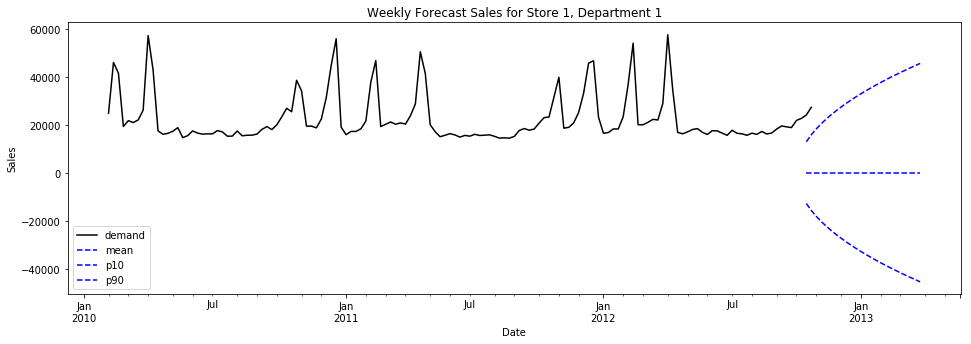

In [31]:
fig, ax = plt.subplots(figsize=(16,5))
hist.plot(x="timestamp",y="demand",ax=ax, color='black')
mean.plot(x="Date",y="sales",ax=ax, color='blue', style='--', label="mean")
p10.plot(x="Date",y="sales",ax=ax, color='blue', style='--', label="p10")
p90.plot(x="Date",y="sales",ax=ax, color='blue', style='--', label="p90")
ax.set_title("Weekly Forecast Sales for Store 1, Department 1")
ax.set_ylabel("Sales")
plt.show()